In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests

### Generating dynamic url based on today's date

In [204]:
def get_seismic_data(base_url, min_magnitude=3.5):
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = datetime.today() - timedelta(days=365)  # Initial guess (1 year back)
    
    while True:
        url = f"{base_url}?format=geojson&starttime={start_date.strftime('%Y-%m-%d')}&endtime={end_date}&minmagnitude={min_magnitude}"
        response = requests.get(url)
        data = response.json()
        
        if 'features' in data and len(data['features']) > 2000:
            start_date += timedelta(days=30)  # Move start date forward to reduce results
        else:
            break  # Found a valid range within the 2000 limit

    return url, start_date

base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
dynamic_url, start_date = get_seismic_data(base_url)
print("Generated API URL:", dynamic_url)
print("Start date", start_date)

Generated API URL: https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2025-02-11&endtime=2025-03-18&minmagnitude=3.5
Start date 2025-02-11 10:25:03.171915


In [205]:
r = requests.get(dynamic_url)
data = r.json()
features = data['features']

features

[{'type': 'Feature',
  'properties': {'mag': 4.4,
   'place': 'Kepulauan Babar, Indonesia',
   'time': 1742255539870,
   'updated': 1742257837040,
   'tz': None,
   'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000pzgs',
   'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000pzgs&format=geojson',
   'felt': None,
   'cdi': None,
   'mmi': None,
   'alert': None,
   'status': 'reviewed',
   'tsunami': 0,
   'sig': 298,
   'net': 'us',
   'code': '6000pzgs',
   'ids': ',us6000pzgs,',
   'sources': ',us,',
   'types': ',origin,phase-data,',
   'nst': 15,
   'dmin': 2.821,
   'rms': 0.89,
   'gap': 115,
   'magType': 'mb',
   'type': 'earthquake',
   'title': 'M 4.4 - Kepulauan Babar, Indonesia'},
  'geometry': {'type': 'Point', 'coordinates': [129.55, -7.3394, 82.042]},
  'id': 'us6000pzgs'},
 {'type': 'Feature',
  'properties': {'mag': 4.5,
   'place': '60 km ESE of Caburan, Philippines',
   'time': 1742252675667,
   'updated': 1742268111040,
   'tz':

In [206]:
earthquakes = []

for earthquake in features:
    properties = earthquake['properties']
    geometry = earthquake['geometry']

    earthquake_data = {
        'place':properties['place'],
        'mag': properties['mag'],
        'time': properties['time'],
        'tsunami': properties['tsunami'],
        'sig': properties['sig'],
        'latitude': geometry['coordinates'][1],
        'longitude': geometry['coordinates'][0],
        'depth': geometry['coordinates'][2],
    }

    earthquakes.append(earthquake_data)

In [207]:
earthquakes_df = pd.DataFrame(earthquakes)
earthquakes_df

,place,mag,time,tsunami,sig,latitude,longitude,depth
0,"Kepulauan Babar, Indonesia",4.4,1742255539870,0,298,-7.3394,129.5500,82.042
1,"60 km ESE of Caburan, Philippines",4.5,1742252675667,0,312,5.6148,126.0966,130.501
2,"51 km SSE of Denali National Park, Alaska",3.9,1742251540796,0,234,63.1053,-151.3726,1.900
3,"52 km SSE of Denali National Park, Alaska",3.6,1742251526021,0,199,63.0870,-151.4697,2.500
4,"Izu Islands, Japan region",4.6,1742250653093,0,326,32.2792,141.1641,35.000
...,...,...,...,...,...,...,...,...
1191,"57 km SE of Calana, Peru",4.6,1739239226735,0,326,-18.2696,-69.7635,114.016
1192,"19 km SW of Amorgós, Greece",4.0,1739237901628,0,246,36.6893,25.7780,10.000
1193,"48 km SE of Akkeshi, Japan",4.6,1739237125694,0,326,42.6978,145.2267,55.638
1194,"140 km SSE of King Cove, Alaska",4.5,1739236190584,0,312,53.8959,-161.4938,13.172


In [208]:
earthquakes_df["tsunami"].value_counts()

tsunami
0    1188
1       8
Name: count, dtype: int64

### Exploring numerical columns

In [209]:
for col in earthquakes_df.columns:
    print(f"Column: {col}")
    print(f"{col}: {earthquakes_df[col].describe()}")
    print("\n")
    

Column: place
place: count                          1196
unique                         1022
top       south of the Fiji Islands
freq                             31
Name: place, dtype: object


Column: mag
mag: count    1196.000000
mean        4.456597
std         0.434862
min         3.500000
25%         4.200000
50%         4.400000
75%         4.700000
max         6.500000
Name: mag, dtype: float64


Column: time
time: count    1.196000e+03
mean     1.740519e+12
std      8.617220e+08
min      1.739233e+12
25%      1.739768e+12
50%      1.740480e+12
75%      1.741128e+12
max      1.742256e+12
Name: time, dtype: float64


Column: tsunami
tsunami: count    1196.000000
mean        0.006689
std         0.081546
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: tsunami, dtype: float64


Column: sig
sig: count    1196.000000
mean      314.916388
std        76.659054
min       188.000000
25%       271.000000
50%       298.000000
7

In [210]:
## Formating 'time' column

earthquakes_df['datetime'] = pd.to_datetime(earthquakes_df['time'], unit='ms').dt.strftime("%B %d, %Y %H:%M")
earthquakes_df.drop("time", axis = 1, inplace=True)


In [237]:
def load_earthquake_data():
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = datetime.today() - timedelta(days=365)
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    min_magnitude = 3

    while True:
        url = f"{base_url}?format=geojson&starttime={start_date.strftime('%Y-%m-%d')}&endtime={end_date}&minmagnitude={min_magnitude}"
        response = requests.get(url)
        data = response.json()
        
        if 'features' not in data:
            raise ValueError("No 'features' key in the API response. Check the API URL or parameters.")
        
        if len(data['features']) <= 2000:
            break  # Exit the loop if the data is within the limit
        
        # Move start date forward to reduce results
        start_date += timedelta(days=30)

    features = data['features']
    earthquakes = []

    for earthquake in features:
        properties = earthquake['properties']
        geometry = earthquake['geometry']

        earthquake_data = {
            'place': properties['place'],
            'mag': properties['mag'],
            'time': properties['time'],
            'tsunami': properties['tsunami'],
            'sig': properties['sig'],
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2],
        }

        earthquakes.append(earthquake_data)
    
    earthquakes_df = pd.DataFrame(earthquakes)

    # Convert timestamp to datetime
    earthquakes_df['datetime'] = pd.to_datetime(earthquakes_df['time'], unit='ms').dt.strftime("%B %d, %Y %H:%M")
    # Drop unnecessary columns
    earthquakes_df.drop("time", axis = 1, inplace=True)

    return earthquakes_df, start_date

In [238]:
earthquakes_df, start_date =  load_earthquake_data()
earthquakes_df

,place,mag,tsunami,sig,latitude,longitude,depth,datetime
0,"Kepulauan Babar, Indonesia",4.4,0,298,-7.3394,129.5500,82.042,"March 17, 2025 23:52"
1,"60 km ESE of Caburan, Philippines",4.5,0,312,5.6148,126.0966,130.501,"March 17, 2025 23:04"
2,"16 km NW of Anderson, Alaska",3.0,0,139,64.4648,-149.3830,13.200,"March 17, 2025 22:47"
3,"51 km SSE of Denali National Park, Alaska",3.9,0,234,63.1053,-151.3726,1.900,"March 17, 2025 22:45"
4,"52 km SSE of Denali National Park, Alaska",3.6,0,199,63.0870,-151.4697,2.500,"March 17, 2025 22:45"
...,...,...,...,...,...,...,...,...
1373,"57 km SE of Calana, Peru",4.6,0,326,-18.2696,-69.7635,114.016,"February 11, 2025 02:00"
1374,"19 km SW of Amorgós, Greece",4.0,0,246,36.6893,25.7780,10.000,"February 11, 2025 01:38"
1375,"48 km SE of Akkeshi, Japan",4.6,0,326,42.6978,145.2267,55.638,"February 11, 2025 01:25"
1376,"140 km SSE of King Cove, Alaska",4.5,0,312,53.8959,-161.4938,13.172,"February 11, 2025 01:09"


In [213]:
earthquakes_df.columns

Index(['place', 'mag', 'tsunami', 'sig', 'latitude', 'longitude', 'depth',
       'datetime'],
      dtype='object')

In [214]:
earthquakes_df[['latitude', 'longitude']]

,latitude,longitude
0,-7.3394,129.5500
1,5.6148,126.0966
2,64.4648,-149.3830
3,63.1053,-151.3726
4,63.0870,-151.4697
...,...,...
1373,-18.2696,-69.7635
1374,36.6893,25.7780
1375,42.6978,145.2267
1376,53.8959,-161.4938


### Tectonic Plates

In [215]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

In [216]:
# Load tectonic plate boundaries
plates = gpd.read_file("../data/PB2002_plates.json")

# Check the structure
plates.head()

,LAYER,Code,PlateName,geometry
0,plate,AF,Africa,"POLYGON ((-0.4379 -54.8518, -0.91466 -54.4535,..."
1,plate,AN,Antarctica,"POLYGON ((180 -65.7494, 180 -90, -180 -90, -18..."
2,plate,SO,Somalia,"POLYGON ((32.1258 -46.9998, 32.1252 -46.9975, ..."
3,plate,IN,India,"POLYGON ((56.2652 14.6232, 57.0015 14.6601, 57..."
4,plate,AU,Australia,"MULTIPOLYGON (((-180 -32.30415, -180 -15.62071..."


In [217]:
# Convert latitude/longitude into geometry
geometry = [Point(lon, lat) for lon, lat in zip(earthquakes_df['longitude'], earthquakes_df['latitude'])]
earthquakes_gdf = gpd.GeoDataFrame(earthquakes_df, geometry=geometry, crs="EPSG:4326")

# Perform spatial join to assign tectonic plates
earthquakes_with_plates = gpd.sjoin(earthquakes_gdf, plates, how="left", predicate="within")

In [218]:
# Rename columns
earthquakes_with_plates.rename(columns={"PlateName": "tectonic_plate"}, inplace=True)

# Drop unnecesary columns
earthquakes_with_plates.drop(["geometry", "index_right", "LAYER", "Code"], axis=1, inplace=True)

In [219]:
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Kepulauan Babar, Indonesia",4.4,0,298,-7.3394,129.5500,82.042,"March 17, 2025 23:52",Timor
1,"60 km ESE of Caburan, Philippines",4.5,0,312,5.6148,126.0966,130.501,"March 17, 2025 23:04",Sunda
2,"16 km NW of Anderson, Alaska",3.0,0,139,64.4648,-149.3830,13.200,"March 17, 2025 22:47",North America
3,"51 km SSE of Denali National Park, Alaska",3.9,0,234,63.1053,-151.3726,1.900,"March 17, 2025 22:45",North America
4,"52 km SSE of Denali National Park, Alaska",3.6,0,199,63.0870,-151.4697,2.500,"March 17, 2025 22:45",North America
...,...,...,...,...,...,...,...,...,...
1373,"57 km SE of Calana, Peru",4.6,0,326,-18.2696,-69.7635,114.016,"February 11, 2025 02:00",Altiplano
1374,"19 km SW of Amorgós, Greece",4.0,0,246,36.6893,25.7780,10.000,"February 11, 2025 01:38",Aegean Sea
1375,"48 km SE of Akkeshi, Japan",4.6,0,326,42.6978,145.2267,55.638,"February 11, 2025 01:25",Okhotsk
1376,"140 km SSE of King Cove, Alaska",4.5,0,312,53.8959,-161.4938,13.172,"February 11, 2025 01:09",North America


In [220]:
minor_to_major_plate = {
    "Juan de Fuca": "Pacific",
    "Okhotsk": "Eurasia",
    "Burma": "Eurasia",
    "Sunda": "Eurasia",
    "Yangtze": "Eurasia",
    "Amur": "Eurasia",
    "Aegean Sea": "Eurasia",
    "Caribbean": "North America",
    "Sandwich": "South America",
    "Nazca": "South America",
    "Cocos": "North America",
    "Panama": "North America",
    "Philippine Sea": "Pacific",
    "Tonga": "Pacific",
    "New Hebrides": "Pacific",
    "South Bismarck": "Pacific",
    "North Bismarck": "Pacific",
    "Mariana": "Pacific",
    "Kermadec": "Pacific",
    "Altiplano": "South America",
    "Maoke": "Australia",
    "Woodlark": "Australia",
    "Banda Sea": "Australia",
    "Okinawa": "Eurasia",
    "Futuna": "Pacific",
    "North Andes": "South America",
    "Arabia": "Eurasia",
    "Shetland": "Antarctica",
    "Manus": "Pacific",
    "Timor": "Australia",
    "Molucca Sea": "Pacific",
    "Balmoral Reef": "Australia",
    "Somalia": "Africa",
    "India": "Eurasia",
    "Birds Head": "Australia",
    "Easter": "Pacific",
    "Niuafo'ou": "Pacific",
    "Antarctica": "Antarctica",
}

# Assign major plate to each earthquake
earthquakes_with_plates["tectonic_plate"] = earthquakes_with_plates["tectonic_plate"].replace(minor_to_major_plate)

In [221]:
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Kepulauan Babar, Indonesia",4.4,0,298,-7.3394,129.5500,82.042,"March 17, 2025 23:52",Australia
1,"60 km ESE of Caburan, Philippines",4.5,0,312,5.6148,126.0966,130.501,"March 17, 2025 23:04",Eurasia
2,"16 km NW of Anderson, Alaska",3.0,0,139,64.4648,-149.3830,13.200,"March 17, 2025 22:47",North America
3,"51 km SSE of Denali National Park, Alaska",3.9,0,234,63.1053,-151.3726,1.900,"March 17, 2025 22:45",North America
4,"52 km SSE of Denali National Park, Alaska",3.6,0,199,63.0870,-151.4697,2.500,"March 17, 2025 22:45",North America
...,...,...,...,...,...,...,...,...,...
1373,"57 km SE of Calana, Peru",4.6,0,326,-18.2696,-69.7635,114.016,"February 11, 2025 02:00",South America
1374,"19 km SW of Amorgós, Greece",4.0,0,246,36.6893,25.7780,10.000,"February 11, 2025 01:38",Eurasia
1375,"48 km SE of Akkeshi, Japan",4.6,0,326,42.6978,145.2267,55.638,"February 11, 2025 01:25",Eurasia
1376,"140 km SSE of King Cove, Alaska",4.5,0,312,53.8959,-161.4938,13.172,"February 11, 2025 01:09",North America


In [222]:
def get_tectonic_plate_data(earthquakes_df):
    
    plates = gpd.read_file("../data/PB2002_plates.json")

   # Convert latitude/longitude into geometry
    geometry = [Point(lon, lat) for lon, lat in zip(earthquakes_df['longitude'], earthquakes_df['latitude'])]
    earthquakes_gdf = gpd.GeoDataFrame(earthquakes_df, geometry=geometry, crs="EPSG:4326")

    # Perform spatial join to assign tectonic plates
    earthquakes_with_plates = gpd.sjoin(earthquakes_gdf, plates, how="left", predicate="within")

    # Rename columns
    earthquakes_with_plates.rename(columns={"PlateName": "tectonic_plate"}, inplace=True)

    # Drop unnecesary columns
    earthquakes_with_plates.drop(["geometry", "index_right", "LAYER", "Code"], axis=1, inplace=True)

    # Assign major plate to each earthquake
    earthquakes_with_plates["tectonic_plate"] = earthquakes_with_plates["tectonic_plate"].replace(minor_to_major_plate)
    
    return earthquakes_with_plates

In [223]:
earthquakes_with_plates = get_tectonic_plate_data(earthquakes_df)
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Kepulauan Babar, Indonesia",4.4,0,298,-7.3394,129.5500,82.042,"March 17, 2025 23:52",Australia
1,"60 km ESE of Caburan, Philippines",4.5,0,312,5.6148,126.0966,130.501,"March 17, 2025 23:04",Eurasia
2,"16 km NW of Anderson, Alaska",3.0,0,139,64.4648,-149.3830,13.200,"March 17, 2025 22:47",North America
3,"51 km SSE of Denali National Park, Alaska",3.9,0,234,63.1053,-151.3726,1.900,"March 17, 2025 22:45",North America
4,"52 km SSE of Denali National Park, Alaska",3.6,0,199,63.0870,-151.4697,2.500,"March 17, 2025 22:45",North America
...,...,...,...,...,...,...,...,...,...
1373,"57 km SE of Calana, Peru",4.6,0,326,-18.2696,-69.7635,114.016,"February 11, 2025 02:00",South America
1374,"19 km SW of Amorgós, Greece",4.0,0,246,36.6893,25.7780,10.000,"February 11, 2025 01:38",Eurasia
1375,"48 km SE of Akkeshi, Japan",4.6,0,326,42.6978,145.2267,55.638,"February 11, 2025 01:25",Eurasia
1376,"140 km SSE of King Cove, Alaska",4.5,0,312,53.8959,-161.4938,13.172,"February 11, 2025 01:09",North America


## EDA

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

In [225]:
# Most recent seismic activity over 3.0 Mw registered
earthquakes_with_plates = earthquakes_with_plates.sort_values(by="datetime", ascending=False)
earthquakes_with_plates.iloc[0]

place             Kepulauan Babar, Indonesia
mag                                      4.4
tsunami                                    0
sig                                      298
latitude                             -7.3394
longitude                             129.55
depth                                 82.042
datetime                March 17, 2025 23:52
tectonic_plate                     Australia
Name: 0, dtype: object

In [226]:
# Average magnitude by tectonic plate
avg_mag_by_plates = earthquakes_with_plates.groupby("tectonic_plate")["mag"].median().sort_values(ascending=False).reset_index()

# Rename the columns
avg_mag_by_plates = avg_mag_by_plates.rename(columns={"mag": "median_mag"})

# Apply background gradient styling (optional, for display in Jupyter Notebook)
styled_avg_mag_by_plates = avg_mag_by_plates.style.background_gradient(cmap='plasma')

# Display the styled DataFrame
styled_avg_mag_by_plates

,tectonic_plate,median_mag
0,Antarctica,4.700000
1,Caroline,4.600000
2,Africa,4.500000
3,South America,4.500000
4,Australia,4.400000
5,Eurasia,4.400000
6,Pacific,4.400000
7,Anatolia,4.200000
8,North America,3.600000


<Figure size 1200x800 with 0 Axes>

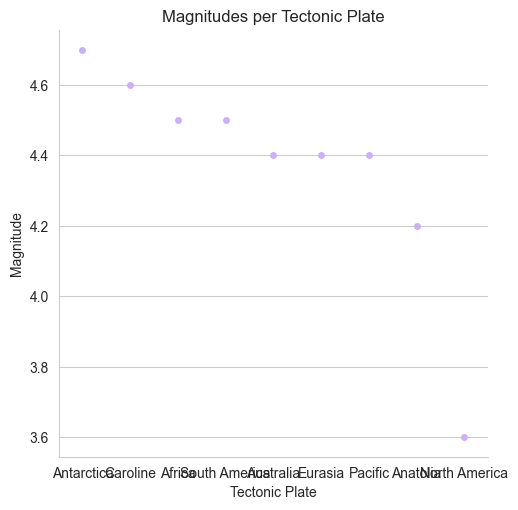

In [227]:
# Define custom colors
color_blue = '#1192e8'
color_blue_light = sns.light_palette(color_blue, n_colors=2)[1]

color_purple = '#a56eff'
color_purple_light = sns.light_palette(color_purple, n_colors=3)[1] 

# Plot
plt.figure(figsize=(12, 8))
sns.catplot(x='tectonic_plate', y='median_mag', data=avg_mag_by_plates, color=color_purple_light, edgecolor=color_purple)
plt.title('Magnitudes per Tectonic Plate')
plt.xlabel('Tectonic Plate')
plt.ylabel('Magnitude')
plt.show()

In [228]:
# Top 10 seismic activity by magnitude and depth
earthquakes_with_plates[['place', 'tectonic_plate', 'mag', 'depth']].sort_values(by=["mag", "depth"], ascending=False).head(10).reset_index().drop(["index"], axis=1).style.background_gradient(cmap='plasma')

,place,tectonic_plate,mag,depth
0,"36 km NNE of Olonkinbyen, Svalbard and Jan Mayen",Eurasia,6.500000,10.000000
1,"103 km WSW of San Pedro de Atacama, Chile",South America,6.100000,93.525000
2,"46 km E of Modisi, Indonesia",Eurasia,6.100000,13.331000
3,"86 km SE of Lata, Solomon Islands",Pacific,6.000000,36.000000
4,South Sandwich Islands region,South America,6.000000,35.379000
5,"4 km N of Metahāra, Ethiopia",Africa,5.900000,25.000000
6,"Nicobar Islands, India region",Eurasia,5.900000,10.000000
7,"102 km NNE of Punta Cana, Dominican Republic",North America,5.850000,46.000000
8,"38 km ESE of Shingū, Japan",Eurasia,5.800000,394.464000
9,"140 km ENE of Masohi, Indonesia",Australia,5.800000,10.000000


In [229]:
earthquakes_with_plates[['place', 'tectonic_plate', 'mag', 'depth']].sort_values(by=["mag", "depth"], ascending=False).head(10).reset_index().drop(["index"], axis=1)["depth"].max()

np.float64(394.464)

In [230]:
# Earthquake depth vs. Magnitude by tectonic plate
earthquakes_with_plates.groupby(['tectonic_plate']).agg(
    count=('mag', 'size'),
    mean_depth=('depth', 'mean'),  
    mean_magnitude=('mag', 'mean'), 
).sort_values(by=["mean_depth", "mean_magnitude"], ascending=False).reset_index()

,tectonic_plate,count,mean_depth,mean_magnitude
0,Australia,190,247.558784,4.486316
1,South America,133,96.501368,4.550376
2,Pacific,265,61.186740,4.299925
3,Eurasia,393,51.417081,4.487277
4,North America,336,35.880493,3.770000
5,Africa,43,12.547907,4.616279
6,Antarctica,16,10.000000,4.787500
7,Caroline,1,10.000000,4.600000
8,Anatolia,1,10.000000,4.200000


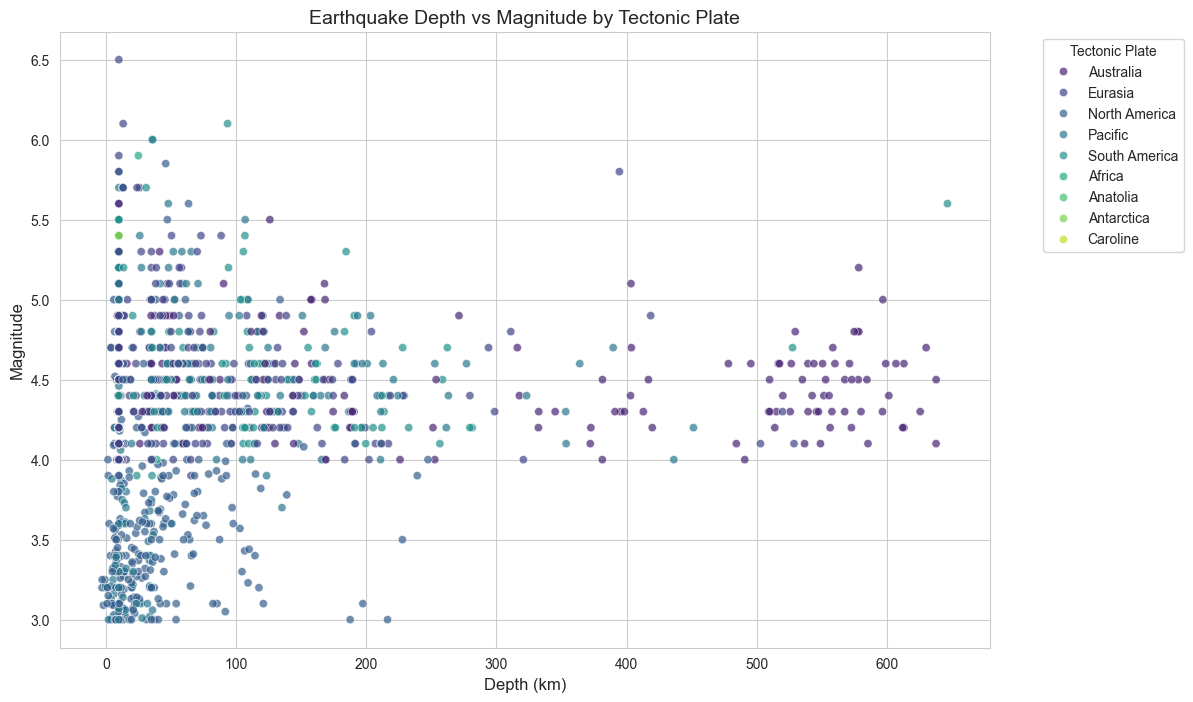

In [231]:
# Set the style for the plot (optional)
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='depth',  # Depth on the x-axis
    y='mag',  # Magnitude on the y-axis
    hue='tectonic_plate',  # Color points by tectonic plate
    data=earthquakes_with_plates,  # Your DataFrame
    palette='viridis',  # Use a color palette (you can customize this)
    alpha=0.7,  # Transparency of points
    edgecolor='w',  # White edges around points
    linewidth=0.5  # Thickness of edges
)

# Add titles and labels
plt.title('Earthquake Depth vs Magnitude by Tectonic Plate', fontsize=14)
plt.xlabel('Depth (km)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

# Add a legend
plt.legend(title='Tectonic Plate', bbox_to_anchor=(1.05, 1), loc='upper left')

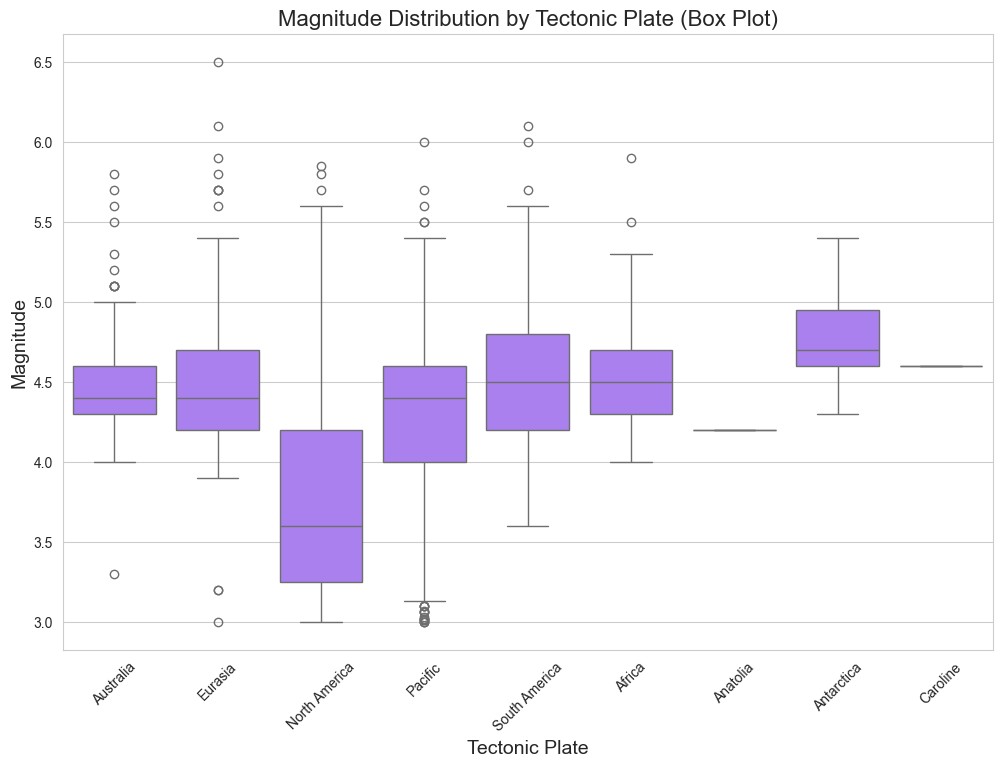

In [232]:
# Magnitude Distribution by Tectonic Plate

magnitude_by_plate = earthquakes_with_plates[['tectonic_plate', 'mag']]

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='tectonic_plate', 
    y='mag', 
    data=magnitude_by_plate, 
    color=color_purple,
)

# Add titles and labels
plt.title('Magnitude Distribution by Tectonic Plate (Box Plot)', fontsize=16)
plt.xlabel('Tectonic Plate', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

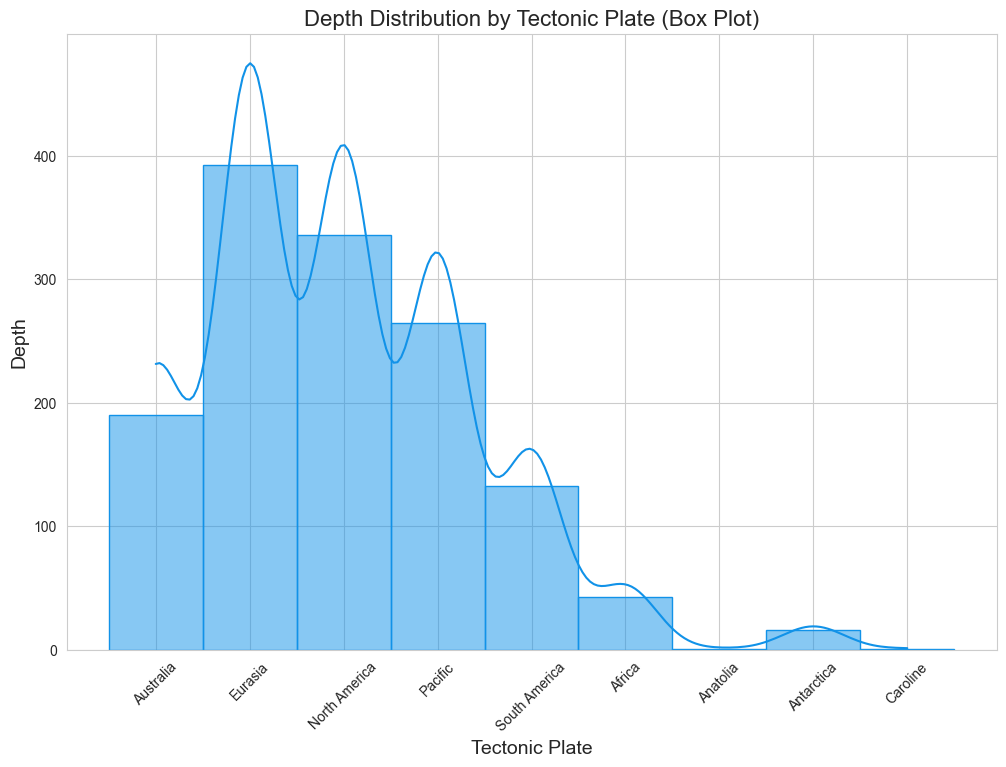

In [233]:
# Depth Distribution by Tectonic Plate

depth_by_plate = earthquakes_with_plates[['tectonic_plate', 'depth']]

# Create a box plot
plt.figure(figsize=(12, 8))
sns.histplot(
    x='tectonic_plate', 
    data=depth_by_plate,
    color=color_blue,
    edgecolor=color_blue_light,
    kde=True
)

# Add titles and labels
plt.title('Depth Distribution by Tectonic Plate (Box Plot)', fontsize=16)
plt.xlabel('Tectonic Plate', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

In [234]:
# HIGHEST AND LOWEST SEISMIC ACTIVITY AND THEIR MAGNITUDE

highest_depth = earthquakes_with_plates[['place','tectonic_plate', 'mag', 'depth']].sort_values(by="depth").head(10).reset_index(drop=True)
lowest_depth = earthquakes_with_plates[['place', 'tectonic_plate', 'mag', 'depth']].sort_values(by="depth", ascending=False).head(10).reset_index(drop=True)

display(highest_depth)
display(lowest_depth)

,place,tectonic_plate,mag,depth
0,"3 km NW of Little America, Wyoming",North America,3.20,-2.94
1,"2 km N of Little America, Wyoming",North America,3.25,-2.79
2,"2 km NW of Little America, Wyoming",North America,3.09,-1.88
3,"11 km SW of Buttonwillow, CA",North America,3.25,-0.70
4,"31 km W of Petrolia, CA",Pacific,3.21,-0.11
5,"52 km S of Denali National Park, Alaska",North America,3.20,0.10
6,"47 km E of Fort Bidwell, California",North America,3.10,0.90
7,"44 km ENE of Fort Bidwell, California",North America,3.20,1.20
8,"50 km SSE of Lavrentiya, Russia",North America,4.00,1.60
9,"51 km SSE of Denali National Park, Alaska",North America,3.90,1.90


,place,tectonic_plate,mag,depth
0,"118 km WNW of Iñapari, Peru",South America,5.6,646.456
1,south of the Fiji Islands,Australia,4.5,637.764
2,Fiji region,Australia,4.1,637.695
3,Fiji region,Australia,4.7,630.086
4,south of the Fiji Islands,Australia,4.3,625.499
5,"250 km E of Levuka, Fiji",Australia,4.2,613.028
6,Fiji region,Australia,4.6,613.026
7,south of the Fiji Islands,Australia,4.2,612.051
8,south of the Fiji Islands,Australia,4.6,606.869
9,"239 km E of Levuka, Fiji",Australia,4.4,601.428


In [235]:
# TECTONIC PLATES BY HIGHEST FREQUENCY
earthquakes_with_plates.groupby(["tectonic_plate"])["place"].count().reset_index().sort_values(by="place", ascending=False).rename(columns={"tectonic_plate":"Tectonic Plate","place":"Frequency"})

,Tectonic Plate,Frequency
5,Eurasia,393
6,North America,336
7,Pacific,265
3,Australia,190
8,South America,133
0,Africa,43
2,Antarctica,16
1,Anatolia,1
4,Caroline,1


In [236]:
# TSUNAMIS

earthquakes_with_plates[earthquakes_with_plates["tsunami"] == 1]

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
143,"56 km WSW of Point Hope, Alaska",5.00,1,385,68.213000,-168.059400,38.50,"March 12, 2025 17:29",North America
211,"36 km NNE of Olonkinbyen, Svalbard and Jan Mayen",6.50,1,656,71.197100,-8.192500,10.00,"March 10, 2025 02:33",Eurasia
223,"10 km NW of Malibu, CA",4.06,1,654,34.068167,-118.894500,11.38,"March 09, 2025 20:03",Pacific
308,"62 km W of Anchor Point, Alaska",4.30,1,295,59.814100,-152.943700,104.30,"March 06, 2025 22:42",North America
402,"2025 Orcas Island, Washington",4.50,1,742,48.611167,-122.805167,15.81,"March 03, 2025 13:02",North America
696,"210 km W of Port McNeill, Canada",5.20,1,426,50.488100,-130.045300,10.00,"February 25, 2025 05:37",Pacific
824,"27 km W of Squamish, Canada",4.80,1,804,49.692300,-123.539200,10.00,"February 21, 2025 21:26",North America
1192,"155 km SSW of Akhiok, Alaska",5.70,1,500,55.615100,-154.917600,13.30,"February 13, 2025 23:59",North America
